In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv('./HistoricalData_Tesla.csv',index_col='Date',parse_dates=True)
df=pd.DataFrame(df[::-1])
df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2013-10-21,$11.5067,172759414,$12.2187,$12.226,$11.40
2013-10-22,$11.436,170788865,$11.3667,$11.852,$11.074
2013-10-23,$10.9667,199788950,$11.2607,$11.454,$10.6767
2013-10-24,$11.5433,161740419,$11.00,$11.6333,$10.855
2013-10-25,$11.3107,113661738,$11.614,$11.6333,$11.12
...,...,...,...,...,...
2023-10-13,$251.12,102296800,$258.90,$259.60,$250.22
2023-10-16,$253.92,88917180,$250.05,$255.3999,$248.48
2023-10-17,$254.85,93562910,$250.10,$257.183,$247.08


In [2]:
#converting non-numeric values to numeric


df['Close/Last'] = pd.to_numeric(df['Close/Last'].str.replace('[^\d.]', '', regex=True), errors='coerce')
df['Open'] = pd.to_numeric(df['Open'].str.replace('[^\d.]', '', regex=True), errors='coerce')
df['High'] = pd.to_numeric(df['High'].str.replace('[^\d.]', '', regex=True), errors='coerce')
df['Low'] = pd.to_numeric(df['Low'].str.replace('[^\d.]', '', regex=True), errors='coerce')

for column in df.columns:
    column_type = df[column].dtype
    print(f"Column '{column}' has type: {column_type}")

Column 'Close/Last' has type: float64
Column 'Volume' has type: int64
Column 'Open' has type: float64
Column 'High' has type: float64
Column 'Low' has type: float64


<function matplotlib.pyplot.show(close=None, block=None)>

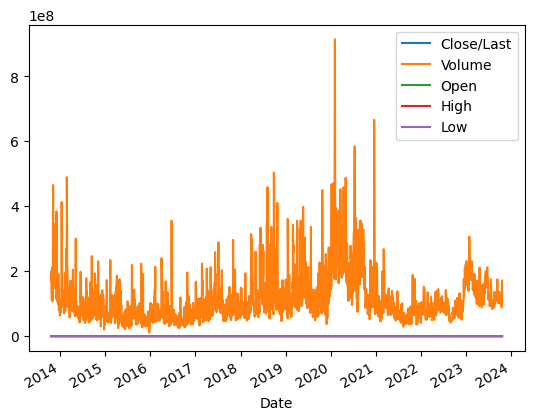

In [3]:
fig, ax=plt.subplots()
df.plot(ax=ax)
plt.show

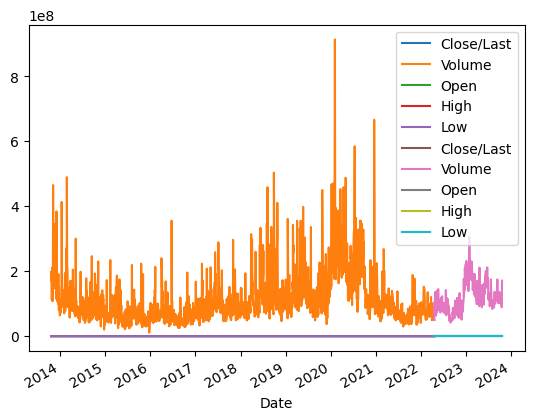

In [4]:
df_train=df.loc[:'04/19/2022']

df_test=df.loc['04/19/2022':]

fig,ax=plt.subplots()

df_train.plot(ax=ax)
df_test.plot(ax=ax)
plt.show()

In [5]:
#dicky-fuller test to see if our data is stationary or not

from statsmodels.tsa.stattools import adfuller

result=adfuller(df_train['Open'])

print(result[0])
print(result[1])
print(result[4])


0.6753904789850647
0.989333728968225
{'1%': -3.4334470946885474, '5%': -2.862908170197601, '10%': -2.5674983485149685}


In [6]:
#differencing once

df_train_stationary = df_train.diff().dropna() # dropping the na values, differencing
result1=adfuller(df_train_stationary['Open'])

print(result1[0])
print(result1[1])
print(result1[4])


-8.244652226130523
5.59626372567968e-13
{'1%': -3.4334470946885474, '5%': -2.862908170197601, '10%': -2.5674983485149685}


In [7]:
#differencing two times

df_train_stationary1 = df_train.diff().diff().dropna() # dropping the na values, differencing
result2=adfuller(df_train_stationary1['Open'])

print(result2[0])
print(result2[1])
print(result2[4])

-14.394341806456955
8.718205301485113e-27
{'1%': -3.433452973124137, '5%': -2.862910765700749, '10%': -2.5674997304642755}


<function matplotlib.pyplot.show(close=None, block=None)>

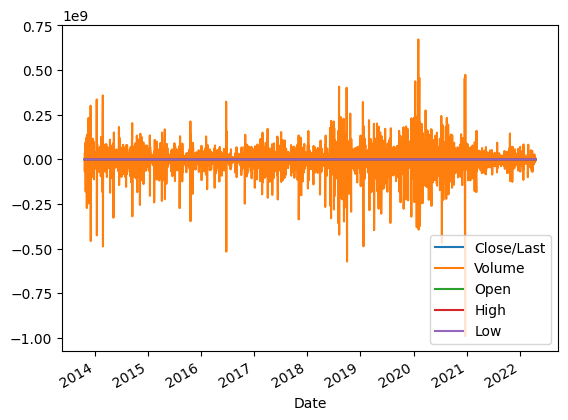

In [8]:
fig, ax=plt.subplots()
df_train_stationary1.plot(ax=ax)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

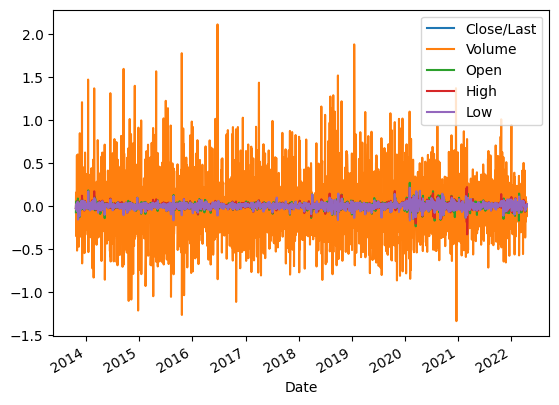

In [9]:
import numpy as np
df_train_log=np.log(df_train/df_train.shift(1))
df_train_log=df_train_log.dropna()

fig, ax=plt.subplots()
df_train_log.plot(ax=ax)
plt.show

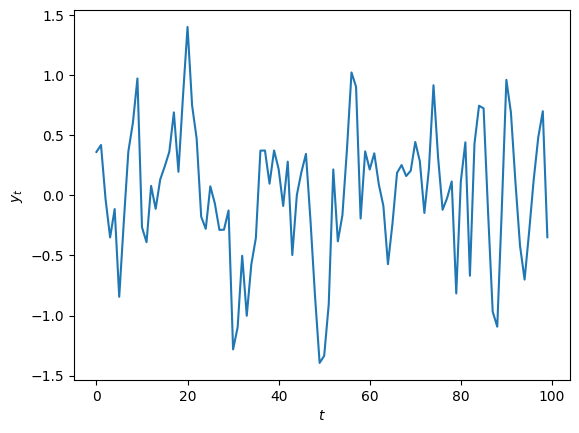

In [10]:
#building a ARMA (auto regressive moving average) model

from statsmodels.tsa.arima_process import arma_generate_sample

ar_coefs=[1,-0.5]
ma_coefs=[1,0.2]

y=arma_generate_sample(ar_coefs,ma_coefs,nsample=100,scale=0.5)

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()

In [11]:
#fitting the ARMA model

from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(y,order=(1,0,1)) # p,d,q = (1,0,1) so for now it is just a ARMA model 
 
#ar_model=ARIMA(timeseries, order=(p,0,0))
#ma_model=ARIMA(timeseries, order=(0,0,q))

results=model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -62.404
Date:                Mon, 27 Nov 2023   AIC                            132.809
Time:                        01:20:45   BIC                            143.229
Sample:                             0   HQIC                           137.026
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.089      0.102      0.919      -0.166       0.184
ar.L1          0.2579      0.173      1.487      0.137      -0.082       0.598
ma.L1          0.4233      0.177      2.398      0.0

In [12]:
#exogenous ARMA: combination of an ARMA model and a linear regression

#model=ARIMA(productivity['study_hours'],order=(2,0,4),exog=productivity['hours_slept'])

In [13]:
#making predictions with non-stationary data (ARIMA)

df_train

model_arima=ARIMA(df_train['Open'], order=(2,1,1))

res=model.fit()

mean_forecast=res.get_forecast(steps=10).predicted_mean



C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


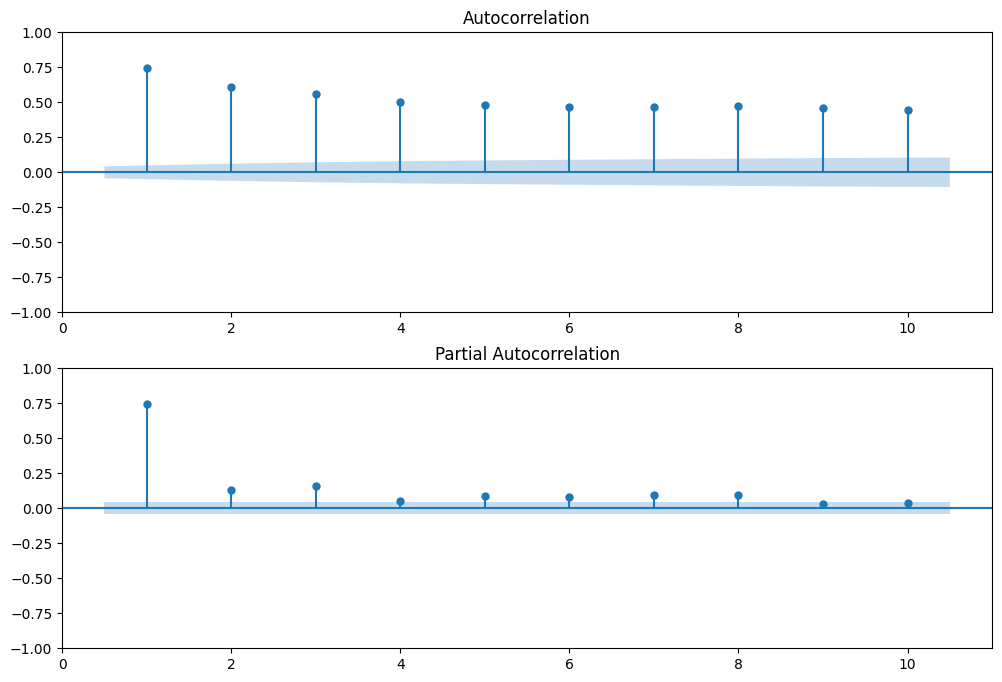

In [14]:
#finding the best orders with ACF anf PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
plot_acf(df_train['Volume'], lags=10, zero=False, ax=ax1)

plot_pacf(df_train['Volume'], lags=10, zero=False, ax=ax2)

plt.show()

#here the acf shows us that our data is not yet stationary

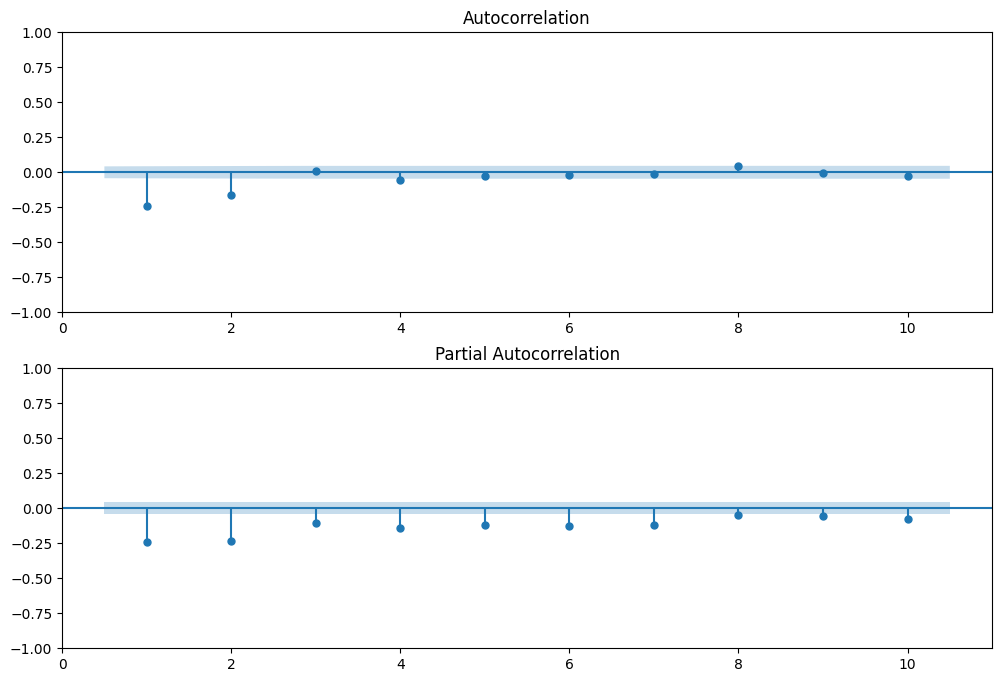

In [15]:
#same thing with the differenced df_train

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
plot_acf(df_train_stationary['Volume'], lags=10, zero=False, ax=ax1)

plot_pacf(df_train_stationary['Volume'], lags=10, zero=False, ax=ax2)

plt.show()

In [16]:
#getting the best p,q values uing AIC and BIC

order_aic_bic=[]

for p  in range(6):
    for q in range(6):
        try:
            model=ARIMA(df_train['Volume'], order=(p,1,q))
            results=model.fit()
            
            order_aic_bic.append((p,q,results.aic,results.bic))
        except:
            order_aic_bic.append((p,q,None,None))
            
order_df=pd.DataFrame(order_aic_bic,columns=['p','q','AIC','BIC'])
print(order_df.sort_values('AIC'))

#we wanna choose the orders with the lowest AIC because we are making a model for predictions
#if we are predicting the Volume, AIC suggests a ARMA(3,3) model (in this case ARIMA(3,1,3))

C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

    p  q           AIC           BIC
17  2  5  82052.320139  82097.661148
5   0  5  82054.295646  82088.301403
10  1  4  82054.303126  82088.308882
11  1  5  82055.541015  82095.214397
16  2  4  82055.970869  82095.644252
15  2  3  82056.427532  82090.433288
32  5  2  82056.807550  82102.148559
21  3  3  82057.082113  82096.755496
23  3  5  82057.386961  82108.395596
33  5  3  82057.567053  82108.575688
9   1  3  82058.101392  82086.439522
20  3  2  82058.159769  82092.165525
22  3  4  82058.437924  82103.778933
27  4  3  82058.809632  82104.150641
26  4  2  82058.977509  82098.650891
28  4  4  82060.077756  82111.086391
4   0  4  82060.231148  82088.569279
29  4  5  82060.626452  82117.302712
31  5  1  82061.012353  82100.685736
34  5  4  82061.047499  82117.723760
14  2  2  82061.412320  82089.750450
25  4  1  82061.413559  82095.419315
35  5  5  82062.852718  82125.196606
8   1  2  82064.331047  82087.001552
19  3  1  82066.537331  82094.875462
13  2  1  82070.079412  82092.749916
7

C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\beben\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

32766309.80604532
                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                 2138
Model:                 ARIMA(0, 1, 4)   Log Likelihood              -41049.559
Date:                Mon, 27 Nov 2023   AIC                          82109.117
Time:                        01:22:06   BIC                          82137.453
Sample:                             0   HQIC                         82119.487
                               - 2138                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4352      0.012   -116.742      0.000      -1.459      -1.411
ma.L2          0.1421      0.024      5.947      0.000       0.095       0.189
ma.L3          0.1815      0.033  

<function matplotlib.pyplot.show(close=None, block=None)>

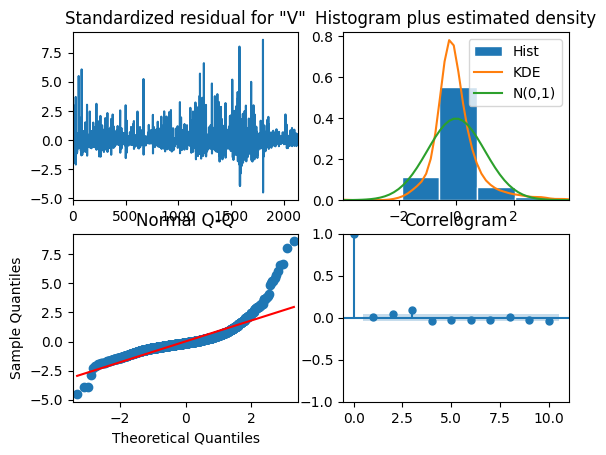

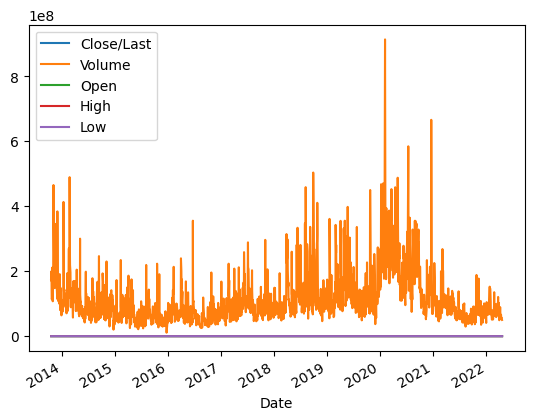

In [17]:
#model diagnostic

_model=ARIMA(df_train_stationary['Volume'],order=(0,1,4))

_results=_model.fit()

_mae=np.mean(np.abs(_results.resid))

print(_mae)
print(_results.summary())

_results.plot_diagnostics()
df_train.plot()
plt.show

#the correlogram as well as the normal Q-Q plot shows that our current model does not fit well for this data